In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [3]:
image_dimensions = {'height':256, 'width':256, 'channels':3}

In [11]:
class Classifier:
    def __init__(self):
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)

    def save(self,path):
        self.model.save_weights(path)
    
    def load(self, path):
        self.model.load_weights(path)

In [12]:
class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)

In [13]:
meso = Meso4()
meso.load(r"C:\Users\APOORVA\deepfake detection\Deepfake-detection\weights\Meso4_DF")

In [14]:
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_directory(
    r'C:\Users\APOORVA\deepfake detection\Deepfake-detection\test',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 3 images belonging to 2 classes.


In [15]:
generator.class_indices

{'deepfake': 0, 'real': 1}

In [16]:
X.shape

(1, 256, 256, 3)

1/1 [==============================] - 0s 97ms/step
Predicted likelihood: 0.0667
Actual label: 0
1/1 [==============================] - 0s 14ms/step

Correct prediction: True


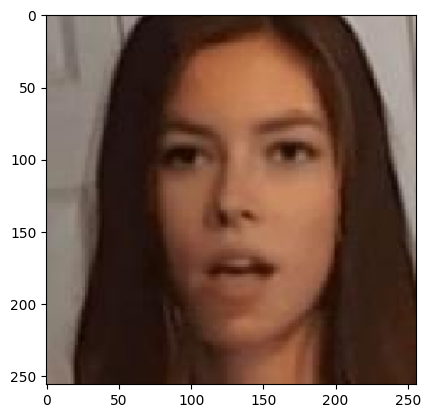

In [17]:
# Rendering image X with label y for MesoNet

X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));

In [18]:
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [19]:
for i in range(len(generator.labels)):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = meso.predict(X)[0][0]
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Printing status update
    if i % 1000 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

1/1 [==============================] - 0s 14ms/step
0  predictions completed.
1/1 [==============================] - 0s 15ms/step
All 3 predictions completed


In [20]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

In [21]:
import pickle 

In [22]:
with open ('model_pickle','wb') as f:
    pickle.dump(meso,f)

In [23]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(meso, 'saved_model.pkl') 

['saved_model.pkl']

In [26]:
meso.save("./weights/my_checkpoint")

In [43]:
plotter(correct_real, correct_real_pred)

ValueError: high <= 0

<Figure size 1600x900 with 0 Axes>

In [44]:
plotter(misclassified_real, misclassified_real_pred)

ValueError: high <= 0

<Figure size 1600x900 with 0 Axes>

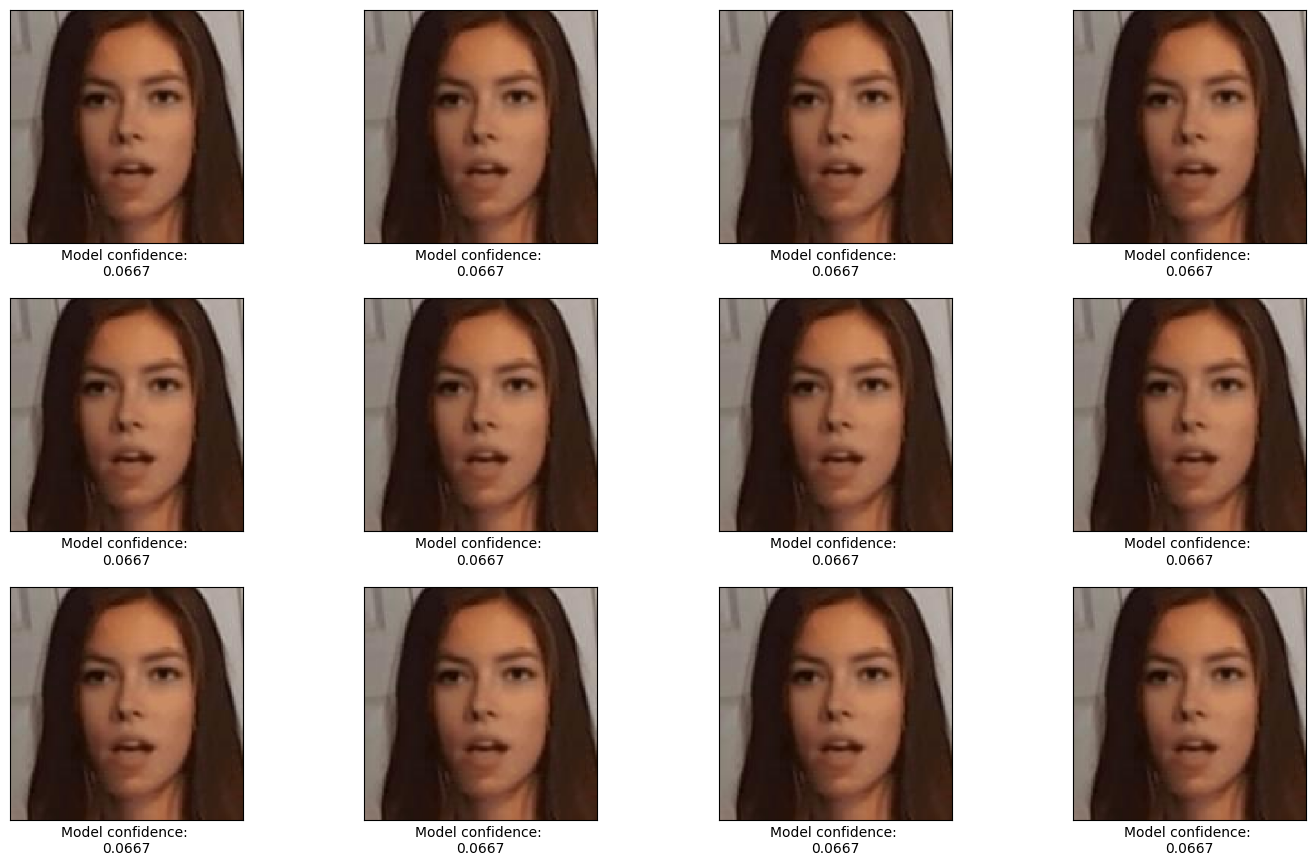

In [46]:
plotter(correct_deepfake, correct_deepfake_pred)

In [47]:
plotter(misclassified_deepfake, misclassified_deepfake_pred)

ValueError: high <= 0

<Figure size 1600x900 with 0 Axes>

NameError: name 'model' is not defined